### Àlex Correa Orri 1564967
### Júlia Pumares Benaiges 1566252

#### Dataset explicat: https://rpubs.com/rhuebner/hrd_cb_v14
#### Descàrrega dataset: https://www.kaggle.com/rhuebner/human-resources-data-set

In [81]:
reset()

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  (), please run `%reset?` for details


### MÒDULS I LLIBRERIES

In [82]:
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats
import os

### DIRECTORI DE TREBALL

In [83]:
os.getcwd()
path = 'C:/Users/alexc/OneDrive/Escritorio/UNI/3er/Aprenentatge Computacional/pràctiques/PRÀCTICA 1'
os.chdir(path)
os.getcwd()
# Visualitzarem només 3 decimals per mostra
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### LECTURA DE DADES

In [84]:
# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

# Carreguem dataset d'exemple
dataset = load_dataset('HRDataset_v14_.csv')
data = dataset.values

x = data[:, :311]
y = data[:, 9]

### INFORMACIÓ DE LES DADES

In [85]:
print("Dimensionalitat de la BBDD:", dataset.shape)
print("Dimensionalitat de les entrades X", x.shape)
print("Dimensionalitat de l'atribut Y", y.shape)

print("Per comptar el nombre de valors no existents:")
print(dataset.isnull().sum())
print("Print dataset:")
print(dataset)
dataset.describe()
list(dataset.columns)

Dimensionalitat de la BBDD: (311, 36)
Dimensionalitat de les entrades X (311, 36)
Dimensionalitat de l'atribut Y (311,)
Per comptar el nombre de valors no existents:
Employee_Name                   0
EmpID                           0
MarriedID                       0
MaritalStatusID                 0
GenderID                        0
EmpStatusID                     0
DeptID                          0
PerfScoreID                     0
FromDiversityJobFairID          0
Salary                          0
Termd                           0
PositionID                      0
Position                        0
State                           0
Zip                             0
DOB                             0
Sex                             0
MaritalDesc                     0
CitizenDesc                     0
HispanicLatino                  0
RaceDesc                        0
DateofHire                      0
DateofTermination             207
TermReason                      0
EmploymentStatus  

['Employee_Name',
 'EmpID',
 'MarriedID',
 'MaritalStatusID',
 'GenderID',
 'EmpStatusID',
 'DeptID',
 'PerfScoreID',
 'FromDiversityJobFairID',
 'Salary',
 'Termd',
 'PositionID',
 'Position',
 'State',
 'Zip',
 'DOB',
 'Sex',
 'MaritalDesc',
 'CitizenDesc',
 'HispanicLatino',
 'RaceDesc',
 'DateofHire',
 'DateofTermination',
 'TermReason',
 'EmploymentStatus',
 'Department',
 'ManagerName',
 'ManagerID',
 'RecruitmentSource',
 'PerformanceScore',
 'EngagementSurvey',
 'EmpSatisfaction',
 'SpecialProjectsCount',
 'LastPerformanceReview_Date',
 'DaysLateLast30',
 'Absences']

### MODIFICACIÓ DEL DATASET

#### ELiminem atributs

In [86]:
dataset = dataset.drop(['Employee_Name', 'MarriedID', 'DeptID', 'Zip', 'ManagerID', 'LastPerformanceReview_Date', 'MaritalStatusID', 'EmpStatusID', 'PositionID', 'Sex', 'PerformanceScore'], axis=1) 
dataset.HispanicLatino = dataset.HispanicLatino.replace({'No': 0, 'Yes': 1})

#### Modifiquem atributs de dates a valors numèrics en dies

In [87]:
def date2date(list_dates):
    list_dates_def = []
    for date in list_dates:
        if (len(date.split('/')[2]) == 2):
            s = date.split('/')
            s[2] = '19'+s[2]
            date = s[0]+'/'+s[1]+'/'+s[2]
        list_dates_def.append(date)
    return list_dates_def

In [88]:
today = '1/1/2020'
#passem les dates (date of hire i date of termination) a date_time
dataset['DateofHire'] = pd.to_datetime(dataset['DateofHire'], format='%m/%d/%Y')
dataset['DateofTermination'].fillna(today, inplace = True) #posem 2020 com a data actual o de referència
dataset['DateofTermination'] = pd.to_datetime(dataset['DateofTermination'], format='%m/%d/%Y')
dataset['WorkedDays'] = dataset['DateofTermination'] - dataset['DateofHire']
dataset = dataset.drop(['DateofTermination', 'DateofHire'], axis=1)
#passem DOB a datetime i ho transformem a edat (per tenir una valor numèric)
dataset['DOB'] = date2date(dataset['DOB'])
dataset['DOB'] = pd.to_datetime(dataset['DOB'], format='%m/%d/%Y')
dataset['Age'] = pd.to_datetime(today, format='%m/%d/%Y') - dataset['DOB']
dataset = dataset.drop(['DOB'], axis=1)

In [89]:
dataset.axes
print(dataset)

list(dataset.columns)

     EmpID  GenderID  PerfScoreID  FromDiversityJobFairID  Salary  Termd  \
0    10026         1            4                       0   62506      0   
1    10084         1            3                       0  104437      1   
2    10196         0            3                       0   64955      1   
3    10088         0            3                       0   64991      0   
4    10069         0            3                       0   50825      1   
..     ...       ...          ...                     ...     ...    ...   
306  10135         1            3                       0   65893      0   
307  10301         0            1                       0   48513      1   
308  10010         0            4                       0  220450      0   
309  10043         0            3                       0   89292      0   
310  10271         0            3                       0   45046      0   

                     Position State MaritalDesc CitizenDesc HispanicLatino  \
0     Pro

['EmpID',
 'GenderID',
 'PerfScoreID',
 'FromDiversityJobFairID',
 'Salary',
 'Termd',
 'Position',
 'State',
 'MaritalDesc',
 'CitizenDesc',
 'HispanicLatino',
 'RaceDesc',
 'TermReason',
 'EmploymentStatus',
 'Department',
 'ManagerName',
 'RecruitmentSource',
 'EngagementSurvey',
 'EmpSatisfaction',
 'SpecialProjectsCount',
 'DaysLateLast30',
 'Absences',
 'WorkedDays',
 'Age']

#### Passem les columnes categòriques a binàries

In [90]:
columns = ['CitizenDesc', 'RaceDesc', 'TermReason', 'EmploymentStatus', 'Department', 'RecruitmentSource', 'Position', 'State', 'ManagerName', 'MaritalDesc']

for col in columns:
    if dataset[col].dtype == 'object':
        print(col)
        dataset = pd.concat([dataset, pd.get_dummies(dataset[col], prefix=col)], axis=1)


CitizenDesc
RaceDesc
TermReason
EmploymentStatus
Department
RecruitmentSource
Position
State
ManagerName
MaritalDesc


In [93]:
dataset = dataset.drop(['CitizenDesc', 'RaceDesc', 'TermReason', 'EmploymentStatus', 'Department', 'RecruitmentSource', 'Position', 'State', 'ManagerName', 'MaritalDesc'], axis=1) 

Mitjana de salari de nois a l'empresa:  70629.4
Mitjana de salari de noies a l'empresa:  67786.72727272728
Màxim salari de nois a l'empresa:  178000
Màxim salari de noies a l'empresa:  250000


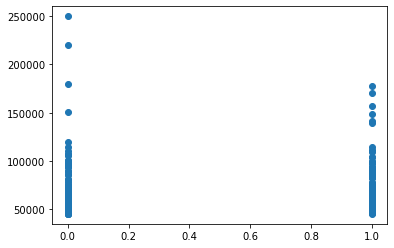

In [164]:
# mostrem el salari en relació al gènere

plt.figure()

ax = plt.scatter(x[:,4], y)

print("Mitjana de salari de nois a l'empresa: ",dataset[dataset['GenderID'] == 1]['Salary'].mean())
print("Mitjana de salari de noies a l'empresa: ",dataset[dataset['GenderID'] == 0]['Salary'].mean())
print("Màxim salari de nois a l'empresa: ",dataset[dataset['GenderID'] == 1]['Salary'].max())
print("Màxim salari de noies a l'empresa: ",dataset[dataset['GenderID'] == 0]['Salary'].max())

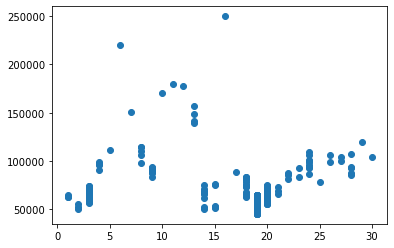

In [165]:
#Salari en funció de la posició
plt.figure()

ax = plt.scatter(x[:,11], y)

### HISTOGRAMA

#### Quantitat d'empleats segons el gènere

KeyError: 'EmpID'

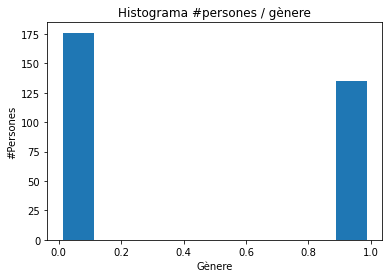

In [166]:
plt.figure()
plt.title("Histograma #persones / gènere")
plt.xlabel("Gènere")
plt.ylabel("#Persones")
v = 4
hist = plt.hist(x[:,v], bins=8, range=[np.min(x[:,v]), np.max(x[:,v])], histtype="bar", rwidth=0.8)
print("Nombre de nois a l'empresa: ",dataset[dataset['GenderID'] == 1]['EmpID'].count())
print("Nombre de noies a l'empresa: ",dataset[dataset['GenderID'] == 0]['EmpID'].count())

#### Quantitat de persones per rangs de salaris a continuació. Es veu com poques persones cobren molt i la majoria es troba en sous més bàsics

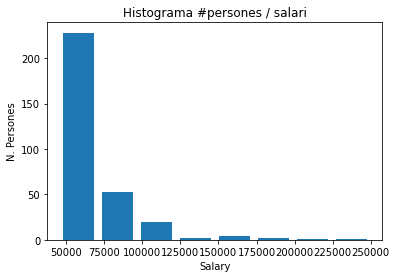

In [167]:
plt.figure()
plt.title("Histograma #persones / salari")
plt.xlabel("Salary")
plt.ylabel("N. Persones")
v = 9
hist = plt.hist(x[:,v], bins=8, range=[np.min(x[:,v]), np.max(x[:,v])], histtype="bar", rwidth=0.8)

### CORRELACIÓ

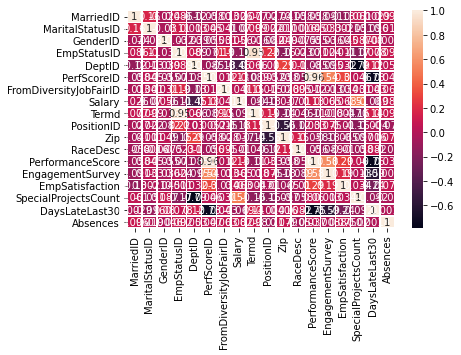

In [ ]:
import seaborn as sns

# Mirem la correlació entre els atributs d'entrada per entendre millor les dades
correlacio = dataset.corr()

plt.figure()

ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

# Mirem la relació entre atributs utilitzant la funció pairplot
relacio = sns.pairplot(dataset)